<a href="https://colab.research.google.com/github/federicocampo/CMEPDA-Project/blob/main/CMEPDA-Project/WaveletDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning our repository to import all the needed functions.

In [ ]:
!git clone https://github.com/federicocampo/CMEPDA-Project.git

Cloning into 'CMEPDA-Project'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 250 (delta 2), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (250/250), 4.26 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [ ]:
%cd /content/CMEPDA-Project/CMEPDA-Project/

/content/CMEPDA-Project


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Importing libearies and setting a logger

To be noted: every comment in the code refers to the code line below the comment itself.

In [ ]:
import os
from PIL import Image
import pywt
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import glob
import multiprocessing as mp

from keras.layers import BatchNormalization, Dense, Flatten, Activation, Dropout, Input
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

from sklearn.model_selection import KFold

from waveletconverter import dwtcoefftoarray

import logging

# Setting a logger and a logging level
logger = logging.getLogger('Mylogger')
logger.setLevel(logging.DEBUG)
# Setting an handler to send logging output
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# Set the format of every log message printing the name of logger, logging level and the message.
formatter = logging.Formatter('%(name)s (%(levelname)s): %(message)s')
ch.setFormatter(formatter)
# Add the specified handler to this logger.
logger.addHandler(ch)

#Reading the images

In [ ]:
PATH = '/content/gdrive/My Drive/IMAGES/Mammography_micro'

def read_img(image_path):
  ''' Takes as input the path to the image folder and 
      returns the numpy array of images and label found in that folder
  '''

  # Creating a list of all image names found in image_path
  imagefilename = glob.glob(os.path.join(image_path, '*.pgm'))

  # Defining 4 sub-processes and apply Immage.open to all the images found
  pool = mp.Pool(processes=4)
  results = pool.map_async(Image.open, imagefilename)

  # Gets the list of images
  images = results.get()

  logger.info(f'Num images found in {image_path}: {len(images)}')

  # Creates the list of corrisponding labels and convert it to numpy array
  label = os.path.basename(image_path)
  y = [int(label)] * len(images)
  y_np = np.array(y)

  return images, y_np


# Defines the path to folder 0 contained in Train. These mammograms do not contain microcalcifications.
image_path = os.path.join(PATH, 'Train/0')
# Creates the train images and labels arrays with the read_img function.
images0_train, y0_train = read_img(image_path)

# Defines the path to folder 1 contained in Train. These mammograms do contain microcalcifications.
image_path = os.path.join(PATH, 'Train/1')
# Creates the train images and labels arrays with the read_img function.
images1_train, y1_train = read_img(image_path)

# Creates a list containing both 0 and 1 labelled images and an array containing both 0 and 1 labels associated to the images.
images_train = images0_train + images1_train
y_train = np.concatenate((y0_train, y1_train))

# The same process is repeated on the Test folder.
image_path = os.path.join(PATH, 'Test/0')
images0_test, y0_test = read_img(image_path)

image_path = os.path.join(PATH, 'Test/1')
images1_test, y1_test = read_img(image_path)

images_test = images0_test + images1_test
y_test = np.concatenate((y0_test, y1_test))

images_tot = images_test + images_train
labels = np.concatenate((y_test, y_train))

Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Train/0: 209
Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Train/1: 187
Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Test/0: 205
Mylogger (INFO): Num images found in /content/gdrive/My Drive/IMAGES/Mammography_micro/Test/1: 196


#Defining the wavelet type

In [ ]:
'''Defines the wavelet family, the level of decomposition, 
   if we want to previously denoise the images, and if we want 
   all the coefficients or only the second and third level coefficients (for 3-lvl
   decomposition) or the second, third and fourth level coefficients (for 4-lvl 
   decomposition).
'''
wavelet = 'sym3'
level = 4
denoise = 'no'
partial = True

# Defines a list to put all coefficients in
coefficients = []

# Appends to the previous list the coefficients obtained from wavelet decomposition
for i, image in enumerate(images_tot):
  array = dwtcoefftoarray(images_tot[i], wavelet, level, denoise, partial)
  coefficients.append(array)

# Converts the list to a numpy array
coefficients = np.array(coefficients)



/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [ ]:
print(coefficients.shape[1])

1527


#Defining and training a model 

##Defining the model

In [ ]:
def make_model(shape):
  ''' Takes as input the shape of coefficients array and returns the 
      keras.model class.
  '''
  model = Sequential([
                      Input(shape = shape),

                      BatchNormalization(),
                      Dense(5, activation='relu'),
                      BatchNormalization(),
                      Dense(5, activation = 'relu'),
                      BatchNormalization(),
                      Dense(5, activation = 'relu'),
                      BatchNormalization(),

                      Dense(1, activation='sigmoid')
  ])
  return model

ModelCheckpoint: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
# Set a checkpoint to save weights giving the best performance on val_accuracy 
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

Model.compile: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

In [ ]:
''' Defines the model and compile it
'''
model = make_model(coefficients.shape[1])
model.compile(optimizer = Adam(lr = 0.005), metrics = 'accuracy', loss='binary_crossentropy')

##Training it

Model.fit: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
''' Training the model using the coefficients and labels arrays and doing a validation split of 30%
'''

val_split = 0.3

history = model.fit(coefficients, labels, 
                    validation_split=val_split, 
                    epochs=40, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)

Text(0.5, 1.0, 'Accuracy and val_accuracy')

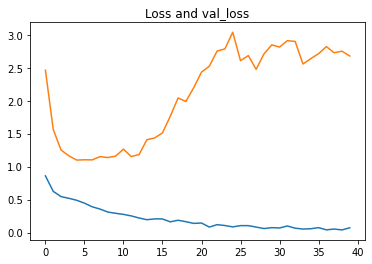

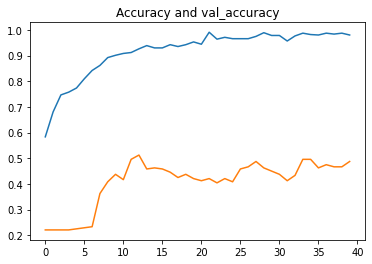

In [ ]:
''' Plots loss, val_loss, accuracy and val_accuracy obtanined during the train
''' 
plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss and val_loss')

plt.figure(2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy and val_accuracy')

#CV Test

In [ ]:
# Creates per-fold accuracy and loss lists
acc_per_fold = []
loss_per_fold = []

# Defines the number of folds to split dataset on
num_folds = 10
# Defining the function kfold which is used to split the dataset
kfold = KFold(n_splits = num_folds, shuffle=True)

batch_size = 32
num_epochs = 50

fold_num = 1

# Defines the model and compiles it
model = make_model(coefficients.shape[1])
model.compile(optimizer=Adam(lr = 0.001), metrics = 'accuracy', loss='binary_crossentropy')
# Saving the weights before training as reset before each training
model.save_weights('reset_model.h5')

for train, test in kfold.split(coefficients, labels):
  ''' Training the model and test it for every fold created 
      from the total original dataset
  '''
  # Reset the untrained model weights saved before
  model.load_weights('reset_model.h5')
  # Fitting the model using every folder (but one) as training
  history = model.fit(
          coefficients[train], labels[train],
          batch_size = batch_size,
          verbose=0,
          epochs = num_epochs)  
  
  # Evaluates the efficiency of the model
  scores = model.evaluate(coefficients[test], labels[test], verbose=0)
  # Printing the results of the training
  print(f'In folder {fold_num}: {model.metrics_names[0]} of {scores[0]} - {model.metrics_names[1]} of {scores[1]}')
  
  
  # Visualize loss and accuracy obtanined during the train for each fold  
  plt.figure(fold_num)
  plt.suptitle(f'In fold num. {fold_num}')
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.plot(history.history['loss'])
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.plot(history.history['accuracy'])
  
  
  # Putting scores on to the corrisponding list to calculate the mean value ot them at the end
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold_num += 1

# Computing and printing average scores
print('Average scores for all folds:')
print(f'-- Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# Calculare loss error as maximum value error
err_loss = (max(loss_per_fold)-min(loss_per_fold))/2
print(f'-- Loss: {np.mean(loss_per_fold)} +/- {err_loss}')